# Chrome Dinosaur game reinforcement learning

## 1. Install dependencies

In [4]:
# for super fast screen capture
from mss import mss
# for fast button presses
import pydirectinput
import cv2 as cv
import numpy as np
# for ocr (optical character recognition)
import pytesseract
from matplotlib import pyplot as plt
import time
# base env class
from gym import Env
from gym.spaces import Box, Discrete

## 2. Build custom environment

### 2.1 Build env

In [20]:
class WebGame(Env):
    def __init__(self) -> None:
        super().__init__()
        
        # === Define spaces
        self.observation_space = Box(low=0, high=255, shape=(83,100,1), dtype=np.uint8)
        # can be 0, 1 or 2
        # 0 = up, 1 = down, 2 = no op
        self.action_space = Discrete(3)

        # === Define extraction parameters
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 800, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
    def step(self, action):
        # take action
        action_map = {
            0: 'up',
            1: 'down',
            # 2 is no op
        }
        
        if action != 2:
            pydirectinput.press(action_map[action])
        
        # get infos
        done = self.get_done()
        obs = self.get_observation()
        
        # reward for every frame alive
        if done:
            reward = 0
        else:
            reward = 1
        
        info = {}
        
        return obs, reward, done, info
    
    def render(self):
        # omiting function
        pass
    
    def reset(self):
        time.sleep(2)
        
        # this is really to make sure we are tabbed into the game
        pydirectinput.click(150, 150)
        
        pydirectinput.press('space')
        
        return self.get_observation()
    
    # non standart functions
    def get_observation(self):
        # get screenshot
        obs = np.array(self.cap.grab(self.game_location))
        
        # channels are BGRA
        obs = obs[..., :3]
        
        obs = cv.cvtColor(obs, cv.COLOR_BGR2GRAY)
        
        obs = cv.resize(obs, (100, 83))
        obs = np.expand_dims(obs, -1)
        
        return obs
    
    def close(self) -> None:
        return super().close()
    
    def get_done(self, print_found=False):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_cap = done_cap[..., :3]
        
        # search for these strings
        done_strings = ['GAME', 'GAHE', 'GANE']
        
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if print_found:
            print(res)
        
        if res in done_strings:
            done = True
        
        return done

In [21]:
env = WebGame()

In [ ]:
print(type(env.reset()))

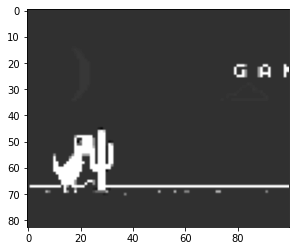

In [22]:
obs = env.get_observation()
plt.imshow(obs, cmap='gray')

In [ ]:
env.get_done(True)

### 2.2 Test env

In [ ]:
env = WebGame()
games = 2

# time.sleep(5)
for i in range(games):
    done = False
    env.reset()
    total_reward = 0
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total reward of episode {i} was {total_reward}')

In [ ]:
from stable_baselines3.common import env_checker

In [ ]:
env_checker.check_env(env)

## 3. Train model

### 3.1 create call back

In [7]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [9]:
CHECKPOINT_DIR = './dino/train' # for model weights
LOG_DIR = './dino/log' # for tf logs

In [18]:
callback = TrainAndLoggingCallback(check_freq=2000, save_path=CHECKPOINT_DIR)

### Build and drain DQN

In [11]:
from stable_baselines3 import DQN

In [17]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=500000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=500000, learning_starts=1000, learning_rate=0.00001)
model.set_parameters('./dino/train/first/best_model_3000.zip')

In [19]:
model.learn(total_timesteps=10000, callback=callback)

Logging to ./dino/log\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 13.2     |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 34       |
|    total_timesteps  | 57       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.6     |
|    ep_rew_mean      | 13.6     |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 65       |
|    total_timesteps  | 117      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.4     |
|    ep_rew_mean      | 13.4     |
|    exploration_rate | 0.836    |
| time/               |    

## 4. Test model

In [23]:
model = model.load('./dino/train/first/best_model_3000.zip')

c:\Users\phiga\miniconda3\envs\gym-retro\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.31GB > 7.07GB
  "This system does not have apparently enough memory to store the complete "


In [28]:
env = WebGame()
games = 3

# time.sleep(5)
for i in range(games):
    done = False
    obs = env.reset()
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += reward
        time.sleep(.01)
    print(f'Total reward of episode {i} was {total_reward}')

1
1
1
1
1
1
1
1
1
1
0
Total reward of episode 0 was 10
1
1
1
1
1
1
1
1
1
1
1
0
Total reward of episode 1 was 11
1
1
1
1
1
1
1
1
1
1
1
1
1
0
Total reward of episode 2 was 13


### 4.1 check execution times

In [30]:
prediction_times = []
step_times = []

env = WebGame()
games = 3

# time.sleep(5)
for i in range(games):
    done = False
    obs = env.reset()
    total_reward = 0
    while not done:
        tic = time.time()
        action, _ = model.predict(obs)
        prediction_times.append(time.time()-tic)
        
        tic = time.time()
        obs, reward, done, info = env.step(int(action))
        step_times.append(time.time()-tic)
        
        total_reward += reward
        time.sleep(.01)
    print(f'Total reward of episode {i} was {total_reward}')

Total reward of episode 0 was 11
Total reward of episode 1 was 9
Total reward of episode 2 was 12


In [31]:
print(sum(prediction_times)/len(prediction_times))
print(sum(step_times)/len(step_times))

0.0063335009983607705
0.4179679393768311


In [32]:
steps_times

[0.47577738761901855,
 0.47913050651550293,
 0.4661533832550049,
 0.4658677577972412,
 0.46674323081970215,
 0.4790496826171875,
 0.4752993583679199,
 0.4732387065887451,
 0.14272570610046387,
 0.1439208984375,
 0.14875340461730957,
 0.16026759147644043,
 0.46022963523864746,
 0.477924108505249,
 0.47597742080688477,
 0.4788386821746826,
 0.47898316383361816,
 0.46079468727111816,
 0.465700626373291,
 0.4654996395111084,
 0.46545958518981934,
 0.4812815189361572,
 0.4928858280181885,
 0.46488499641418457,
 0.46593761444091797,
 0.47983503341674805,
 0.46363186836242676,
 0.4639739990234375,
 0.4789717197418213,
 0.47989869117736816,
 0.14454126358032227,
 0.4848487377166748,
 0.15027880668640137,
 0.4751698970794678,
 0.4964027404785156]

step takes very long (0.4s). The value is either ~.37 or ~.14

Investigating further

In [38]:
tic = time.time()
for i in range(100):
    pydirectinput.press('down')
print((time.time()-tic)/100)

0.3256617832183838


In [44]:
import win32com.client as comclt
wsh = comclt.Dispatch("WScript.Shell")
# wsh.AppActivate("Steam") # select another application

wsh.SendKeys("down")
wsh.SendKeys("down")
wsh.SendKeys("down")
wsh.SendKeys("down")
wsh.SendKeys("down")

In [46]:
import pyautogui

tic = time.time()
for i in range(100):
    pyautogui.press('down')
print((time.time()-tic)/100)

0.10878110885620117


In [35]:
tic = time.time()
for i in range(100):
    env.get_done()
print((time.time()-tic)/100)

0.13391414880752564


In [36]:
tic = time.time()
for i in range(100):
    env.get_observation()
print((time.time()-tic)/100)

0.016595473289489748


TODO:
- test win32 keypress
- optimize get_done function
    - reduce capture size
    - reduce capture channels
    - maybe first check timeuser (probably tesseract)